In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch import optim
from torch.autograd import Variable

In [2]:
from torchvision import datasets,transforms
#root_dir = "/kaggle/input/flowers-recognition/flowers/flowers"
root_dir = "../input/flowers-recognition"
flower_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
flower_dataset = datasets.ImageFolder(root_dir,transform=flower_transform)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

In [4]:
flower_dataset

Dataset ImageFolder
    Number of datapoints: 4317
    Root location: ../input/flowers-recognition
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [5]:
len(flower_dataset)

4317

In [6]:
flower_dataset.classes

['flowers']

In [7]:
index =  list(range(len(flower_dataset)))
import random
random.shuffle(index)
random.shuffle(index)
# for shuffling data
print(index[:50])

[137, 2178, 822, 468, 1169, 2758, 2360, 1556, 3440, 1945, 95, 4269, 1943, 3658, 3110, 2021, 3327, 1265, 3921, 735, 1153, 1103, 2502, 341, 2716, 3205, 969, 201, 1004, 1728, 1350, 2442, 1761, 1321, 3155, 3119, 1246, 3684, 2139, 3349, 399, 857, 2957, 3716, 3549, 3495, 1929, 1434, 4296, 2164]


In [8]:
test_indeces = int(np.ceil(len(flower_dataset)*0.1))
val_indeces = int(np.ceil(len(flower_dataset)*0.1))
train_indeces = int(np.ceil(len(flower_dataset)*0.80))
test_sampler = torch.utils.data.SubsetRandomSampler(index[:test_indeces])
val_sampler = torch.utils.data.SubsetRandomSampler(index[test_indeces:val_indeces+test_indeces])
train_sampler = torch.utils.data.SubsetRandomSampler(index[val_indeces+test_indeces:train_indeces])

In [9]:
test = torch.utils.data.DataLoader(flower_dataset,batch_size=32, sampler=test_sampler)
val = torch.utils.data.DataLoader(flower_dataset, batch_size=32, sampler=val_sampler)
train = torch.utils.data.DataLoader(flower_dataset,batch_size=32, sampler=train_sampler)

In [10]:
num_epochs = 10
num_classes = 5
learning_rate = 0.01

In [11]:
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

In [12]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [13]:
vgg.classifier[6].out_features = num_classes
for param in vgg.features.parameters(): param.requires_grad = False

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=learning_rate)

In [15]:
import torch.nn.functional as F
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    l=433
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            l=3457
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/l
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{l}{accuracy:{10}.{4}}')
    return loss,accuracy

In [16]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,vgg,train,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,vgg,val,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is  0.12 and training accuracy is 2558/3457     73.99
validation loss is   0.0 and validation accuracy is 432/433     99.77
training loss is   0.0 and training accuracy is 2590/3457     74.92
validation loss is   0.0 and validation accuracy is 432/433     99.77
training loss is   0.0 and training accuracy is 2590/3457     74.92
validation loss is   0.0 and validation accuracy is 432/433     99.77
training loss is   0.0 and training accuracy is 2590/3457     74.92
validation loss is   0.0 and validation accuracy is 432/433     99.77
training loss is   0.0 and training accuracy is 2590/3457     74.92
validation loss is   0.0 and validation accuracy is 432/433     99.77
training loss is   0.0 and training accuracy is 2590/3457     74.92
validation loss is   0.0 and validation accuracy is 432/433     99.77
training loss is   0.0 and training accuracy is 2590/3457     74.92
validation loss is   0.0 and validation accuracy is 432/433     99.77
training loss is   0.0 and trainin

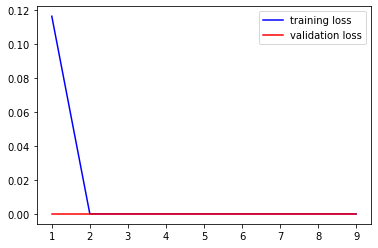

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(1,len(train_losses)+1),train_losses,'b',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

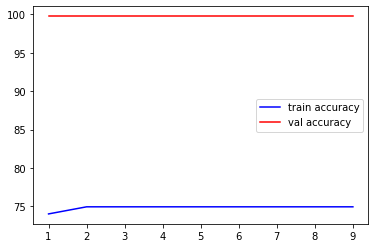

In [18]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'b',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()

In [19]:
vgg.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test:
        images = images.to(device)
        labels = labels.to(device)
        outputs = vgg(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 100.0 %
